<a href="https://colab.research.google.com/github/Fantiflex/Modular_Manifold_Muon/blob/main/main_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import pickle
import argparse
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms


from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")

%run "/content/drive/MyDrive/Colab_notebooks/EECS182_project/copy_hyperspherical_descent.ipynb"
%run "/content/drive/MyDrive/Colab_notebooks/EECS182_project/copy_LGFBS_global.ipynb"
# after this, the functions defined inside those notebooks are available in the current notebook
from torch.optim import AdamW
from torch.utils.data import DataLoader

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -------------------------------------------------------------------
# SEEDS ET OUTILS RANDOM
# -------------------------------------------------------------------
DEFAULT_SEEDS = [0, 15, 42, 65]

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# -------------------------------------------------------------------
# DATA (CIFAR-100)
# -------------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.49139968, 0.48215827, 0.44653124),
        (0.24703233, 0.24348505, 0.26158768),
    ),
])

train_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

# -------------------------------------------------------------------
# Outils pour condition spectrale (MuOn / AdamW)
# -------------------------------------------------------------------

def spectral_clip(W, max_sigma=0.1, n_power_iter=1):
    """
    Approximate ||W||_2 via power iteration, et si > max_sigma,
    on rescales W pour que ||W||_2 ≈ max_sigma.
    W : tensor 2D (out_features, in_features)
    """
    if W.ndim != 2:
        return

    # vecteur u initial
    u = torch.randn(W.size(0), device=W.device)
    u = u / (u.norm() + 1e-12)

    for _ in range(n_power_iter):
        v = W.t().mv(u)
        v = v / (v.norm() + 1e-12)
        u = W.mv(v)
        u = u / (u.norm() + 1e-12)

    sigma = u @ (W @ v)
    sigma = sigma.abs()

    if sigma > max_sigma:
        W.mul_(max_sigma / (sigma + 1e-12))


# -------------------------------------------------------------------
# MODELS
# -------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, hidden_dim=512, num_classes=100):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc3 = nn.Linear(hidden_dim, num_classes, bias=False)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class SimpleCNN(nn.Module):
    """
    CNN simple pour CIFAR-100.
    On peut passer les convs et le fc sous Muon / L-BFGS (aplaties).
    """
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes, bias=False)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)              # [B, 256, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 256]
        x = self.fc(x)                # [B, num_classes]
        return x


class SimpleViT(nn.Module):
    """
    Petit Vision Transformer pour CIFAR-100.

    - Image 32x32 -> patchs 4x4 -> 8x8=64 patchs.
    - Embedding de patchs (Linear 48 -> embed_dim).
    - Positional embedding appris.
    - 2 couches TransformerEncoder (d_model=128, 4 heads).
    - Average pooling sur les tokens -> Linear vers 100 classes.
    """
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_chans=3,
        num_classes=100,
        embed_dim=128,
        depth=2,
        num_heads=4,
        mlp_ratio=4.0,
    ):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans

        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_chans * patch_size * patch_size

        # Matrice 2D -> parfait pour Muon/L-BFGS
        self.patch_embed = nn.Linear(patch_dim, embed_dim, bias=False)

        # Embedding de position
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes, bias=False)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size

        p = self.patch_size
        x = x.reshape(B, C, H // p, p, W // p, p)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()
        x = x.view(B, -1, C * p * p)        # [B, num_patches, patch_dim]

        x = self.patch_embed(x)             # [B, num_patches, embed_dim]
        x = x + self.pos_embed              # [B, num_patches, embed_dim]

        x = self.encoder(x)                 # [B, num_patches, embed_dim]
        x = x.mean(dim=1)                   # [B, embed_dim]

        x = self.norm(x)
        x = self.head(x)                    # [B, num_classes]
        return x


def build_model(model_type: str) -> nn.Module:
    model_type = model_type.lower()
    if model_type == "mlp":
        return MLP()
    elif model_type == "cnn":
        return SimpleCNN()
    elif model_type == "vit":
        return SimpleViT()
    else:
        raise ValueError(f"Unknown model_type: {model_type}")


# -------------------------------------------------------------------
# RIEMANNIAN SGD SUR STIEFEL (projection par SVD)
# -------------------------------------------------------------------
def project_stiefel_svd(W: torch.Tensor) -> torch.Tensor:
    """
    Projection de W sur la variété de Stiefel via SVD :
    W ≈ U V^T avec U,V orthogonales (U @ Vh a colonnes orthonormées).
    Fonctionne pour matrices rectangulaires.
    """
    # full_matrices=False => U: (m,k), Vh: (k,n) avec k = min(m,n)
    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    return U @ Vh


def riemannian_sgd_update(W: torch.Tensor, G: torch.Tensor, eta: float) -> torch.Tensor:
    """
    Un pas de SGD euclidien suivi d'une retraction Stiefel.
    - W : matrice 2D (ou poids conv aplatis dans ton code)
    - G : gradient euclidien
    - eta : pas de gradient
    """
    # 1) step euclidien
    W_eucl = W - eta * G

    # 2) retraction sur Stiefel via projection SVD
    W_new = project_stiefel_svd(W_eucl)
    return W_new



# -------------------------------------------------------------------
# GLOBAL STATE FOR L-BFGS
# -------------------------------------------------------------------
OPTS = {}  # map: param -> ManifoldLBFGS instance

# -------------------------------------------------------------------
# UTILS POUR LA NORME SPECTRALE DU PAS (NOUVEAU)
# -------------------------------------------------------------------
def tensor_to_matrix(W: torch.Tensor) -> torch.Tensor:
    """
    Convertit un tenseur de poids en matrice 2D pour la norme spectrale.
    - Linear: (out_features, in_features) -> inchangé
    - Conv: (out_channels, in_channels, kH, kW) -> (out_channels, in_channels * kH * kW)
    - Autres: première dim = lignes, reste aplati en colonnes.
    """
    if W.ndim == 2:
        return W
    else:
        return W.reshape(W.shape[0], -1)


@torch.no_grad()
def spectral_step_norm(W_old: torch.Tensor, W_new: torch.Tensor) -> float:
    """
    Calcule ||W_new - W_old||_2 (norme spectrale) en voyant les poids comme une matrice.
    """
    delta = W_new - W_old
    M = tensor_to_matrix(delta)
    try:
        spec = torch.linalg.matrix_norm(M, ord=2)
    except TypeError:
        # fallback via SVD si matrix_norm n'est pas dispo
        s = torch.linalg.svdvals(M)
        spec = s[0]
    return spec.item()

# -------------------------------------------------------------------
# TRAIN
# -------------------------------------------------------------------
def train(epochs, initial_lr, update, wd, model_type, use_spectral=True):
    global OPTS
    OPTS = {}  # on reset pour chaque run

    model = build_model(model_type).cuda()
    criterion = nn.CrossEntropyLoss()

    # Cas AdamW vs "update manifold"
    if update == AdamW:
        optimizer = AdamW(model.parameters(), lr=initial_lr, weight_decay=wd)
    else:
        optimizer = None  # Muon / hyperspherical / L-BFGS

    # Est-ce qu'on est dans le cas L-BFGS globalisé ?
    use_lbfgs = (update is manifold_muon_general)

    steps = epochs * len(train_loader)
    step = 0

    # ----- Choix des paramètres à tracer pour la norme spectrale (NOUVEAU) -----
    tracked_names = []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        # On ne regarde que les poids "matrix-like" (2D/4D)
        if p.ndim in (2, 4):
            tracked_names.append(name)

    # Option : filtrer par type de modèle pour éviter le spam
    if model_type == "mlp":
        tracked_names = [n for n in tracked_names
                         if n in ["fc1.weight", "fc2.weight", "fc3.weight"]]
    elif model_type == "cnn":
        tracked_names = [n for n in tracked_names
                         if any(k in n for k in ["conv1.weight",
                                                 "conv2.weight",
                                                 "conv3.weight",
                                                 "fc.weight"])]
    elif model_type == "vit":
        tracked_names = [n for n in tracked_names
                         if any(k in n for k in ["patch_embed.weight",
                                                 "head.weight"])]

    print("Tracked params:", tracked_names)
    step_spectral_logs = {name: [] for name in tracked_names}

    # ----- Projection initiale des paramètres manifold -----
    if optimizer is None:
        with torch.no_grad():
            for p in model.parameters():
                if p.ndim == 2:
                    if use_lbfgs:
                        opt_p = ManifoldLBFGS(eta=initial_lr, history=10)
                        OPTS[p] = opt_p
                        p.data = manifold_muon_general(
                            p.data,
                            torch.zeros_like(p.data),
                            eta=0.0,
                            opt=opt_p,
                        )
                    else:
                        p.data = update(p.data, torch.zeros_like(p.data), eta=0.0)

                elif p.ndim == 4:
                    shape = p.shape
                    W = p.data.view(shape[0], -1)
                    Z = torch.zeros_like(W)
                    if use_lbfgs:
                        opt_p = ManifoldLBFGS(eta=initial_lr, history=10)
                        OPTS[p] = opt_p
                        W_new = manifold_muon_general(W, Z, eta=0.0, opt=opt_p)
                    else:
                        W_new = update(W, Z, eta=0.0)
                    p.data.copy_(W_new.view(shape))
                # Le reste (bias, LayerNorm, pos_embed...) reste euclidien

    epoch_losses = []
    epoch_times = []

    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        model.train()

        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            model.zero_grad()
            loss.backward()

            lr = initial_lr * (1 - step / steps)

            with torch.no_grad():
                if optimizer is None:
                    # --------- Cas Muon / hyperspherical / L-BFGS ---------
                    W_old_dict = {}
                    if tracked_names:
                        for name, p in model.named_parameters():
                            if name in tracked_names:
                                W_old_dict[name] = p.data.clone()

                    for p in model.parameters():
                        if p.grad is None:
                            continue

                        if use_lbfgs and p in OPTS and p.ndim in (2, 4):
                            opt_p = OPTS[p]

                            if p.ndim == 2:
                                W = p.data
                                G = p.grad
                            else:  # conv 4D
                                shape = p.shape
                                W = p.data.view(shape[0], -1)
                                G = p.grad.view(shape[0], -1)

                            opt_p.update(G)
                            W_new = manifold_muon_general(W, G, eta=lr, opt=opt_p)

                            if p.ndim == 2:
                                p.data.copy_(W_new)
                            else:
                                p.data.copy_(W_new.view(shape))

                        else:
                            if p.ndim == 2:
                                p.data = update(p.data, p.grad, eta=lr)
                            elif p.ndim == 4:
                                shape = p.shape
                                W = p.data.view(shape[0], -1)
                                G = p.grad.view(shape[0], -1)
                                W_new = update(W, G, eta=lr)
                                p.data.copy_(W_new.view(shape))
                            else:
                                p.data = p.data - lr * p.grad

                    if tracked_names:
                        for name, p in model.named_parameters():
                            if name in tracked_names:
                                W_old = W_old_dict[name]
                                W_new = p.data
                                spec_norm = spectral_step_norm(W_old, W_new)
                                step_spectral_logs[name].append(
                                    {
                                        "step": step,
                                        "lr": lr,
                                        "spec_norm": spec_norm,
                                    }
                                )

                else:
                    # --------- Cas AdamW (+ projection spectrale optionnelle) ---------
                    for param_group in optimizer.param_groups:
                        param_group["lr"] = lr
                    optimizer.step()

                    if use_spectral and model_type == "vit":
                        for module in model.modules():
                            if isinstance(module, nn.Linear):
                                spectral_clip(module.weight, max_sigma=0.1)

            step += 1
            running_loss += loss.item()

            if (i + 1) % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], "
                    f"Loss: {loss.item():.4f}"
                )

        end_time = time.time()
        epoch_loss = running_loss / len(train_loader)
        epoch_time = end_time - start_time
        epoch_losses.append(epoch_loss)
        epoch_times.append(epoch_time)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Time: {epoch_time:.4f} seconds")

    return model, epoch_losses, epoch_times, step_spectral_logs

# -------------------------------------------------------------------
# EVAL
# -------------------------------------------------------------------
def eval(model):
    model.eval()
    with torch.no_grad():
        accs = []
        for dataloader in [test_loader, train_loader]:
            correct = 0
            total = 0
            for images, labels in dataloader:
                images = images.cuda()
                labels = labels.cuda()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accs.append(100.0 * correct / total)

    print(
        f"Accuracy of the network on the {len(test_loader.dataset)} test images: "
        f"{accs[0]} %"
    )
    print(
        f"Accuracy of the network on the {len(train_loader.dataset)} train images: "
        f"{accs[1]} %"
    )
    return accs

# -------------------------------------------------------------------
# WEIGHT STATS
# -------------------------------------------------------------------
def weight_stats(model):
    singular_values = []
    norms = []
    for p in model.parameters():
        norms.append(p.norm().item())
        if p.ndim >= 2:
            mat = p.view(p.size(0), -1)
            u, s, v = torch.svd(mat)
            singular_values.append(s)
    return singular_values, norms

# -------------------------------------------------------------------
# SWEEP SUR η (eta) ET SEEDS
# -------------------------------------------------------------------
def sweep_eta_and_seeds(
    model_type: str,
    update_name: str,
    etas,
    epochs: int = 20,
    wd: float = 0.05,
    seeds=None,
    use_spectral=True,
):
    """
    Lance des expériences pour plusieurs valeurs d'eta (initial_lr)
    et plusieurs seeds. Retourne un dict: eta -> liste d'accuracies test.

    model_type : "mlp", "cnn", "vit"
    update_name : "manifold_muon", "manifold_muon_general",
                  "hyperspherical_descent", "adam"
    etas : iterable de valeurs d'eta (float)
    seeds : liste de seeds; par défaut [0, 15, 42, 65]
    """
    if seeds is None:
        seeds = DEFAULT_SEEDS

    update_rules = {
        "manifold_muon": manifold_muon,
        "manifold_muon_general": manifold_muon_general,
        "hyperspherical_descent": hyperspherical_descent,
        "adam": AdamW,
        "riemannian_sgd": riemannian_sgd_update
    }

    if update_name not in update_rules:
        raise ValueError(f"Unknown update_name: {update_name}")

    update_fn = update_rules[update_name]

    results = {}  # eta -> [acc_test_seed1, acc_test_seed2, ...]

    for eta in etas:
        acc_list = []
        print(f"\n========== ETA = {eta} ==========")
        for seed in seeds:
            print(f"-- Seed {seed} --")
            set_seed(seed)

            model, epoch_losses, epoch_times, step_spectral_logs = train(
                epochs=epochs,
                initial_lr=eta,
                update=update_fn,
                wd=wd,
                model_type=model_type,
                use_spectral=use_spectral,
            )

            test_acc, train_acc = eval(model)
            acc_list.append(test_acc)

        results[eta] = acc_list

    return results


def plot_accuracy_vs_eta(eta_results, title=None, log_x=False):
    """
    eta_results : dict {eta: [acc_seed1, acc_seed2, ...]}
    Affiche la moyenne ± écart-type de l'accuracy test en fonction de eta.
    """
    etas = sorted(eta_results.keys())
    means = []
    stds = []

    for eta in etas:
        accs = np.array(eta_results[eta], dtype=float)
        means.append(accs.mean())
        stds.append(accs.std())

    plt.figure()
    plt.errorbar(etas, means, yerr=stds, marker="o", capsize=5)
    plt.xlabel("eta (initial_lr)")
    plt.ylabel("Test accuracy (%)")
    if title is not None:
        plt.title(title)
    if log_x:
        plt.xscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# MAIN
# -------------------------------------------------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train a model on CIFAR-100.")
    parser.add_argument("--model", type=str, default="mlp",
                        choices=["mlp", "cnn", "vit"],
                        help="Model type to use.")
    parser.add_argument("--epochs", type=int, default=5,
                        help="Number of epochs to train for.")
    parser.add_argument("--lr", type=float, default=0.8,
                        help="Initial learning rate.")
    parser.add_argument(
        "--update",
        type=str,
        default="riemannian_sgd",
        choices=["manifold_muon", "manifold_muon_general",
                 "hyperspherical_descent", "riemannian_sgd","adam"],
        help="Update rule to use.",
    )
    parser.add_argument("--seed", type=int, default=42,
                        help="Seed for the random number generator.")
    parser.add_argument("--wd", type=float, default=0.05,
                        help="Weight decay for AdamW.")
    args = parser.parse_args([])  # mets None si tu lances en CLI

    # Determinism (via set_seed)
    set_seed(args.seed)

    # Dictionnaire des règles d'update
    update_rules = {
        "manifold_muon": manifold_muon,
        "manifold_muon_general": manifold_muon_general,
        "hyperspherical_descent": hyperspherical_descent,
        "adam": AdamW,
        "riemannian_sgd": riemannian_sgd_update,
    }
    update = update_rules[args.update]

    print(f"Training {args.model.upper()} on CIFAR-100 with: {args.update}")
    print(
        f"Epochs: {args.epochs} --- LR: {args.lr}"
        + (f" --- WD: {args.wd}" if args.update == "adam" else "")
    )

    model, epoch_losses, epoch_times, step_spectral_logs = train(
        epochs=args.epochs,
        initial_lr=args.lr,
        update=update,
        wd=args.wd,
        model_type=args.model
    )
    test_acc, train_acc = eval(model)
    singular_values, norms = weight_stats(model)

    results = {
        "model": args.model,
        "epochs": args.epochs,
        "lr": args.lr,
        "seed": args.seed,
        "wd": args.wd,
        "update": args.update,
        "epoch_losses": epoch_losses,
        "epoch_times": epoch_times,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "singular_values": singular_values,
        "norms": norms,
        "step_spectral_logs": step_spectral_logs,  # NEW
    }

    filename = (
        f"model-{args.model}-update-{args.update}-lr-{args.lr}"
        f"-wd-{args.wd}-seed-{args.seed}.pkl"
    )
    os.makedirs("results", exist_ok=True)
    save_path = os.path.join("results", filename)
    print(f"Saving results to {save_path}")
    with open(save_path, "wb") as f:
        pickle.dump(results, f)
    print(f"Results saved to {save_path}")


Training CNN on CIFAR-100 with: riemannian_sgd
Epochs: 5 --- LR: 0.8
Tracked params: ['conv1.weight', 'conv2.weight', 'conv3.weight', 'fc.weight']
Epoch 1, Loss: 4.1733, Time: 34.0709 seconds
Epoch 2, Loss: 3.9936, Time: 33.8588 seconds
Epoch 3, Loss: 3.9109, Time: 33.8981 seconds
Epoch 4, Loss: 3.8513, Time: 33.8333 seconds
Epoch 5, Loss: 3.8086, Time: 33.9860 seconds
Accuracy of the network on the 10000 test images: 16.24 %
Accuracy of the network on the 50000 train images: 16.574 %
Saving results to results/model-cnn-update-riemannian_sgd-lr-0.8-wd-0.05-seed-42.pkl
Results saved to results/model-cnn-update-riemannian_sgd-lr-0.8-wd-0.05-seed-42.pkl


Accuracy pour différentes méthodes au fur et à mesure de l'entrainement

In [ ]:
etas = [1]
eta_results_riem = sweep_eta_and_seeds(
    model_type="vit",
    update_name="riemannian_sgd",
    etas=etas,
    epochs=5,
    seeds=[0, 15, 42],
)



========== ETA = 1 ==========
-- Seed 0 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.2427, Time: 19.7938 seconds
Epoch 2, Loss: 4.0099, Time: 19.9690 seconds
Epoch 3, Loss: 3.8459, Time: 19.7190 seconds
Epoch 4, Loss: 3.6782, Time: 20.6104 seconds
Epoch 5, Loss: 3.5083, Time: 19.5053 seconds
Accuracy of the network on the 10000 test images: 17.71 %
Accuracy of the network on the 50000 train images: 19.274 %
-- Seed 15 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.2355, Time: 20.1286 seconds
Epoch 2, Loss: 4.0069, Time: 19.5382 seconds
Epoch 3, Loss: 3.8599, Time: 20.1284 seconds
Epoch 4, Loss: 3.6936, Time: 19.4362 seconds
Epoch 5, Loss: 3.5389, Time: 20.2384 seconds
Accuracy of the network on the 10000 test images: 17.13 %
Accuracy of the network on the 50000 train images: 18.786 %
-- Seed 42 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.2334, Time: 20.0147 seconds
Epoch 2, Loss: 4.0169, Time: 19.417

KeyboardInterrupt: 

Seed and LR sweeping


========== ETA = 0.001 ==========
-- Seed 0 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.1526, Time: 16.8065 seconds
Epoch 2, Loss: 3.6831, Time: 15.4702 seconds
Epoch 3, Loss: 3.4045, Time: 15.3167 seconds
Epoch 4, Loss: 3.1928, Time: 15.7053 seconds
Epoch 5, Loss: 3.0642, Time: 15.6956 seconds
Accuracy of the network on the 10000 test images: 24.8 %
Accuracy of the network on the 50000 train images: 26.718 %
-- Seed 15 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.1719, Time: 15.7116 seconds
Epoch 2, Loss: 3.7081, Time: 15.3907 seconds
Epoch 3, Loss: 3.4286, Time: 16.0235 seconds
Epoch 4, Loss: 3.2205, Time: 15.7521 seconds
Epoch 5, Loss: 3.0977, Time: 15.6560 seconds
Accuracy of the network on the 10000 test images: 23.89 %
Accuracy of the network on the 50000 train images: 25.814 %
-- Seed 42 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.1580, Time: 15.6482 seconds
Epoch 2, Loss: 3.7039, Time: 16.

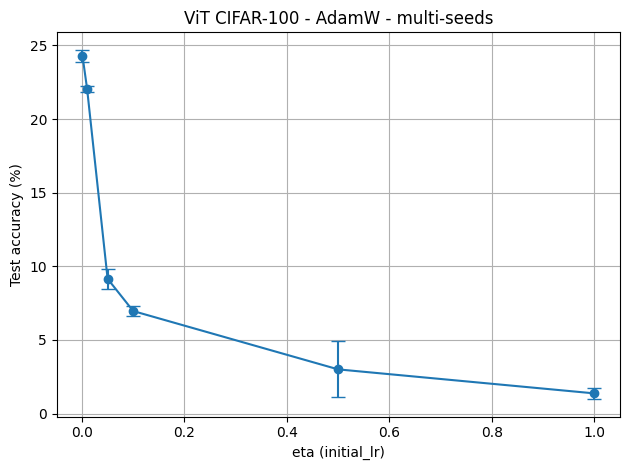

In [ ]:
etas = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

eta_results = sweep_eta_and_seeds(
    model_type="vit",                  # "mlp", "cnn" ou "vit"
    update_name="adam",
    etas=etas,
    epochs=5,
    wd=0.05,                           # utilisé seulement si update="adam"
    seeds=[0, 15, 42, 65],             # ou laisse None pour DEFAULT_SEEDS
    use_spectral=False,                 # pour AdamW + SN sur ViT
)

plot_accuracy_vs_eta(
    eta_results,
    title="ViT CIFAR-100 - AdamW - multi-seeds",
    log_x=False,   # True si tu veux l'axe x en log
)



========== ETA = 0.001 ==========
-- Seed 0 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.1526, Time: 15.2872 seconds
Epoch 2, Loss: 3.6831, Time: 15.1403 seconds
Epoch 3, Loss: 3.4045, Time: 15.5251 seconds
Epoch 4, Loss: 3.1928, Time: 15.9204 seconds
Epoch 5, Loss: 3.0642, Time: 16.9933 seconds
Accuracy of the network on the 10000 test images: 24.8 %
Accuracy of the network on the 50000 train images: 26.718 %
-- Seed 15 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.1719, Time: 15.3368 seconds
Epoch 2, Loss: 3.7081, Time: 15.8395 seconds
Epoch 3, Loss: 3.4286, Time: 15.7041 seconds
Epoch 4, Loss: 3.2205, Time: 15.2435 seconds
Epoch 5, Loss: 3.0977, Time: 15.5325 seconds
Accuracy of the network on the 10000 test images: 23.89 %
Accuracy of the network on the 50000 train images: 25.814 %
-- Seed 42 --
Tracked params: ['patch_embed.weight', 'head.weight']
Epoch 1, Loss: 4.1580, Time: 15.7448 seconds
Epoch 2, Loss: 3.7039, Time: 16.

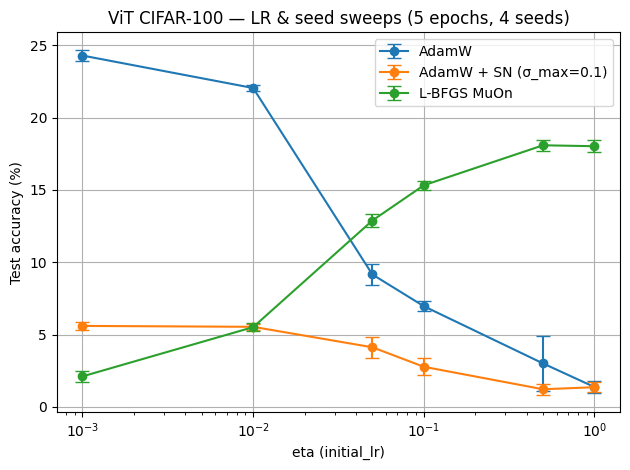

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

etas = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]

# -----------------------------
# 1) Sweeps pour les 3 méthodes
# -----------------------------

# (a) AdamW "nu"
eta_results_adam = sweep_eta_and_seeds(
    model_type="vit",
    update_name="adam",
    etas=etas,
    epochs=5,
    wd=0.05,
    seeds=[0, 15, 42, 65],
    use_spectral=False,    # AdamW sans SN
)

# (b) AdamW + Spectral Norm (σ_max=0.1)
eta_results_adamSN = sweep_eta_and_seeds(
    model_type="vit",
    update_name="adam",
    etas=etas,
    epochs=5,
    wd=0.05,
    seeds=[0, 15, 42, 65],
    use_spectral=True,     # AdamW + SN (via ton spectral_clip dans train)
)

# (c) L-BFGS MuOn (manifold_muon_general)
eta_results_muon = sweep_eta_and_seeds(
    model_type="vit",
    update_name="manifold_muon_general",
    etas=etas,
    epochs=5,
    seeds=[0, 15, 42, 65],
    # use_spectral est ignoré dans ce cas, mais tu peux laisser la valeur par défaut
)


# ------------------------------------------
# 2) Plot : 3 méthodes sur le même graphique
# ------------------------------------------
def plot_three_methods_accuracy_vs_eta(
    eta_results_1,
    eta_results_2,
    eta_results_3,
    label1="AdamW",
    label2="AdamW + SN",
    label3="L-BFGS MuOn",
    title=None,
    log_x=False,
):
    """
    eta_results_i : dict {eta: [acc_seed1, acc_seed2, ...]}
    Trace les 3 courbes (moyenne ± std) sur la même figure.
    """
    # on prend les eta communs aux trois méthodes (au cas où)
    etas = sorted(
        set(eta_results_1.keys())
        & set(eta_results_2.keys())
        & set(eta_results_3.keys())
    )

    def stats(eta_results):
        means, stds = [], []
        for eta in etas:
            accs = np.array(eta_results[eta], dtype=float)
            means.append(accs.mean())
            stds.append(accs.std())
        return np.array(means), np.array(stds)

    means1, stds1 = stats(eta_results_1)
    means2, stds2 = stats(eta_results_2)
    means3, stds3 = stats(eta_results_3)

    plt.figure()

    plt.errorbar(etas, means1, yerr=stds1, marker="o", capsize=5, label=label1)
    plt.errorbar(etas, means2, yerr=stds2, marker="o", capsize=5, label=label2)
    plt.errorbar(etas, means3, yerr=stds3, marker="o", capsize=5, label=label3)

    plt.xlabel("eta (initial_lr)")
    plt.ylabel("Test accuracy (%)")
    if title is not None:
        plt.title(title)
    if log_x:
        plt.xscale("log")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# appel :
plot_three_methods_accuracy_vs_eta(
    eta_results_adam,
    eta_results_adamSN,
    eta_results_muon,
    label1="AdamW",
    label2="AdamW + SN (σ_max=0.1)",
    label3="L-BFGS MuOn",
    title="ViT CIFAR-100 — LR & seed sweeps (5 epochs, 4 seeds)",
    log_x=True,   # mets True si tu veux l’axe LR en log
)
